Using a mix of `partridge` and `gtfstk` with some of my own additions to create daily statistical DataFrames for trips, routes and stops. This will later become a module which we will run on our historical MoT GTFS archive and schedule for nightly runs. 

## Imports and config

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import partridge as ptg
import datetime
import os

#import gtfs_utils as gu
#import gtfstk


In [3]:
import altair as alt
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

## Read files

In [7]:
import glob
rs = (pd.concat([pd.read_pickle(f, compression='gzip') 
                 for f in glob.glob('data\\gtfs_stats_MOD_ffill\\*_route_stats.pkl.gz')])
      .assign(date = lambda x: pd.to_datetime(x.date))
      .assign(dayofweek = lambda x: x['date'].dt.strftime('%A')))

In [8]:
rs.shape

(3129270, 37)

In [9]:
rs.head().T

,0,1,2,3,4
route_id,1,10,10000,10001,10007
route_short_name,1,4,91,91,422
agency_id,25,25,14,14,25
agency_name,אפיקים,אפיקים,נתיב אקספרס,נתיב אקספרס,אפיקים
route_long_name,תחנת רכבת יבנה מערב-יבנה<->תחנת רכבת מזרח-יבנה-1#,תחנת רכבת מזרח-יבנה<->תחנת רכבת יבנה מערב-יבנה-2#,הפלמ''ח-צפת<->דרך חטיבת יפתח-צפת-11,האר''י/ישראל ב''ק-צפת<->שפרינצק/קרן היסוד-צפת-2#,קניון איילון-רמת גן<->המ''ג/ירמיהו-ירושלים-10
route_type,3,3,3,3,3
num_trips,26,35,1,4,77
num_trip_starts,26,35,1,4,77
num_trip_ends,26,35,1,4,70
is_loop,0,0,1,0,0


## Examples

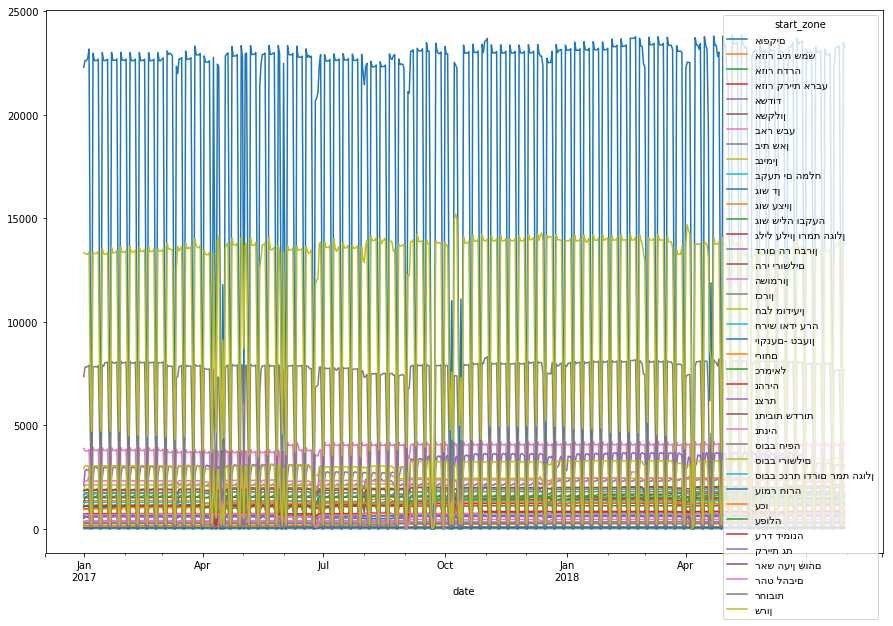

In [10]:
(rs
 .groupby(['date', 'start_zone']).num_trips.sum().unstack().plot(figsize=(15,10)))

In [11]:
total_trips = (rs.set_index('date').resample('D').num_trips.sum().reset_index().groupby(pd.Grouper(key='date', freq='W-SUN')).agg(['min', 'mean', 'max', 'sum']).reset_index())
total_trips.columns = ['date', 'min', 'mean', 'max', 'sum']
total_trips.head()

,date,min,mean,max,sum
0,2017-01-01,80589,80589.000000,80589,80589
1,2017-01-08,16581,68238.714286,84440,477671
2,2017-01-15,16626,68385.000000,84256,478695
3,2017-01-22,16644,68543.714286,84525,479806
4,2017-01-29,16674,68643.000000,84584,480501


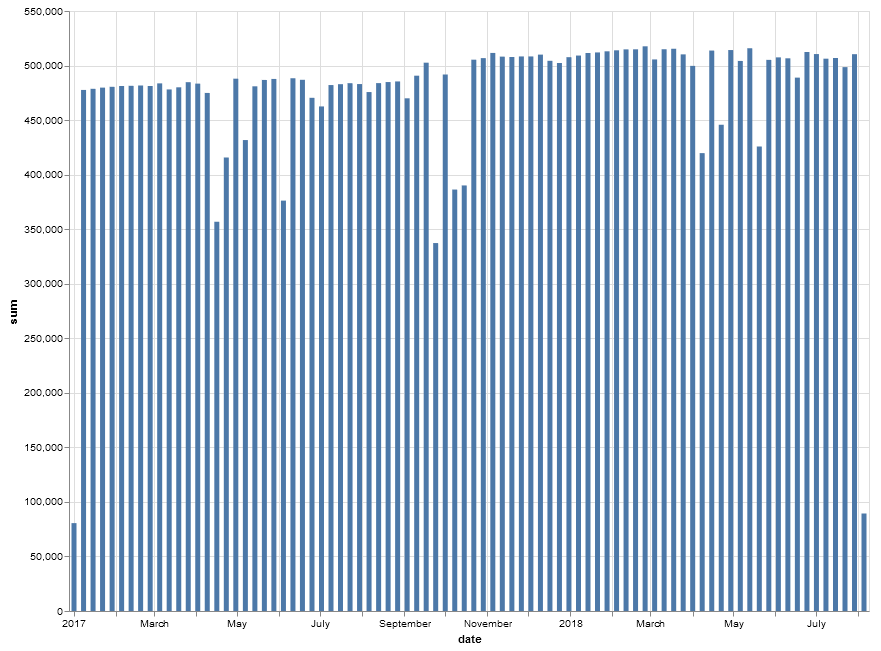

In [12]:
alt.Chart(total_trips).mark_bar().encode(
    x='date:T',
    y='sum:Q',
    tooltip=[ alt.Tooltip('date:T', format='%A, %B %e'),
             alt.Tooltip('sum:Q', format='.0f')],
).properties(width=800, height=600)

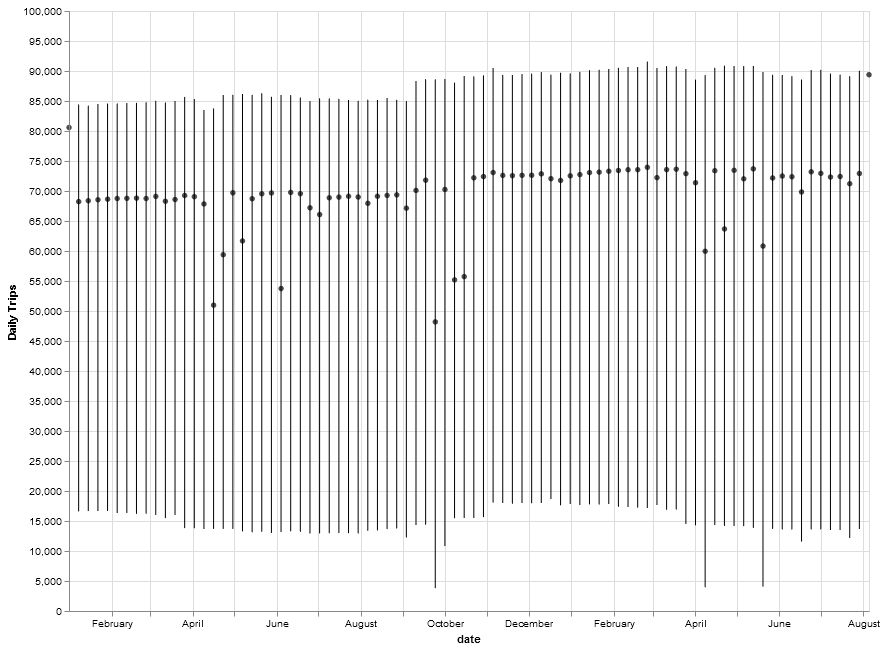

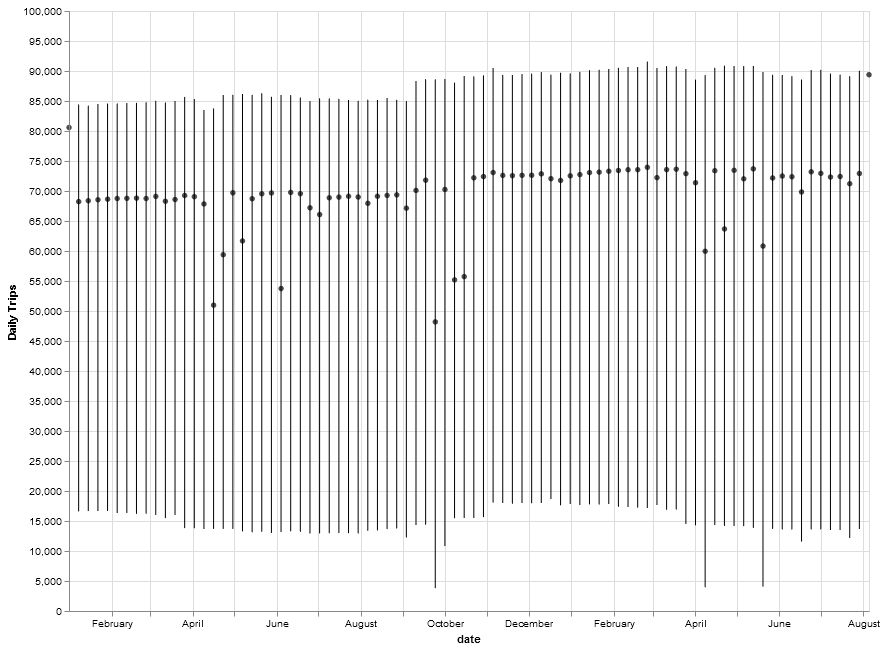

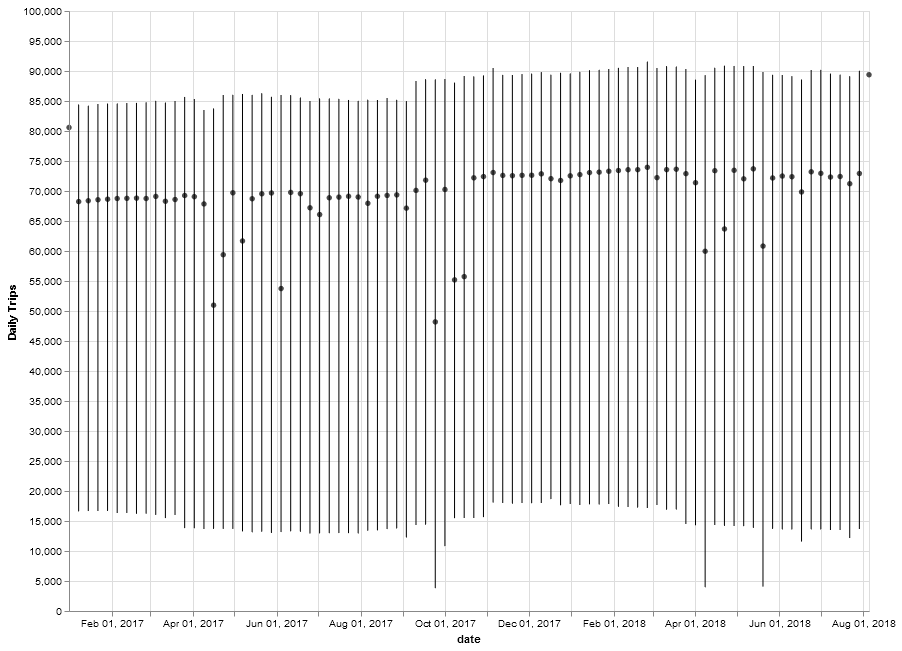

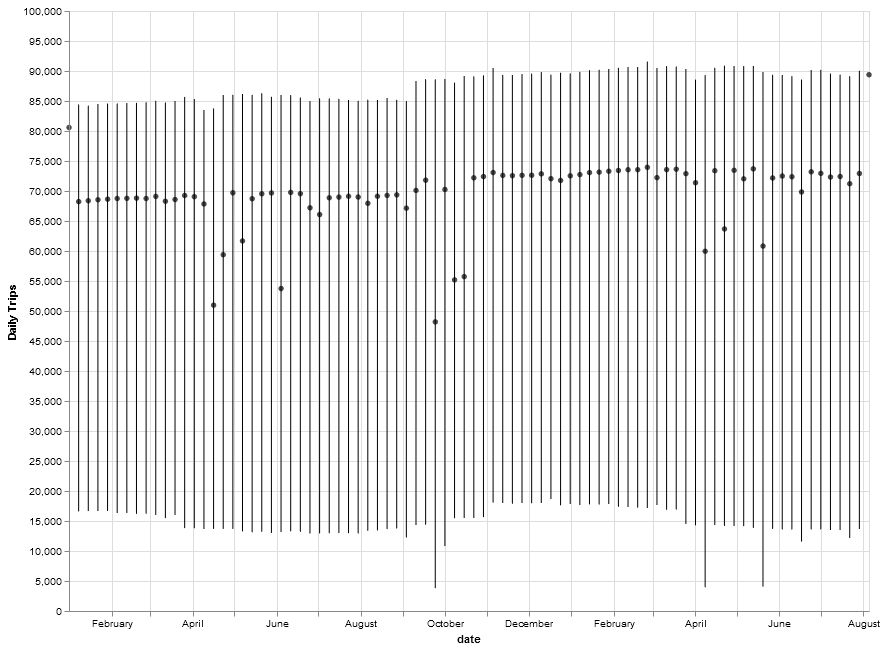

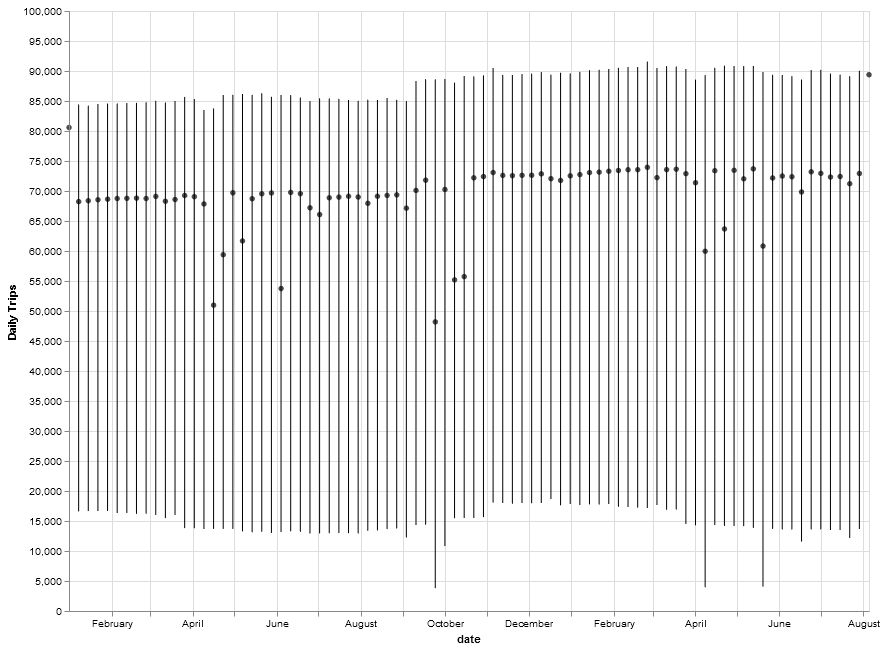

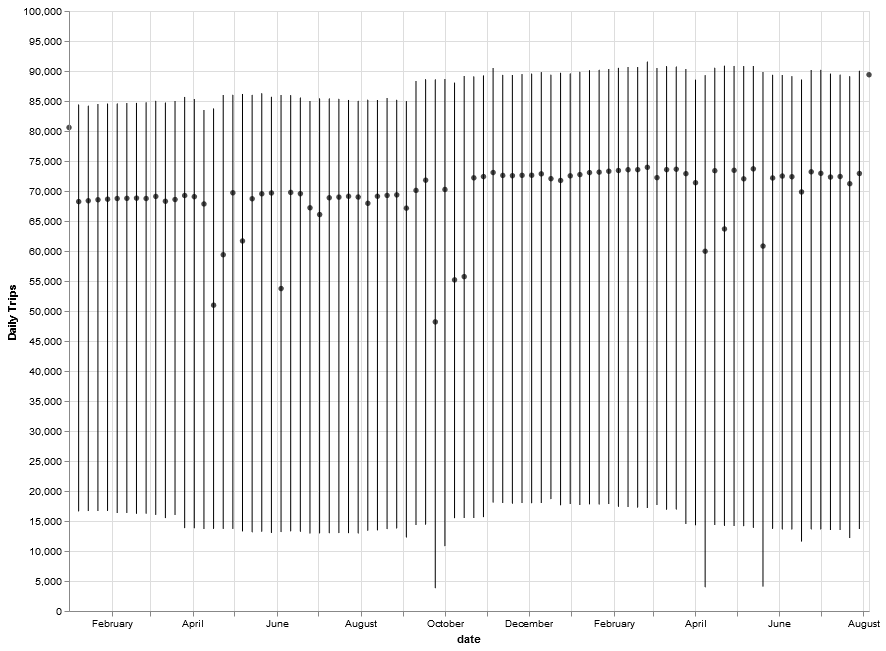

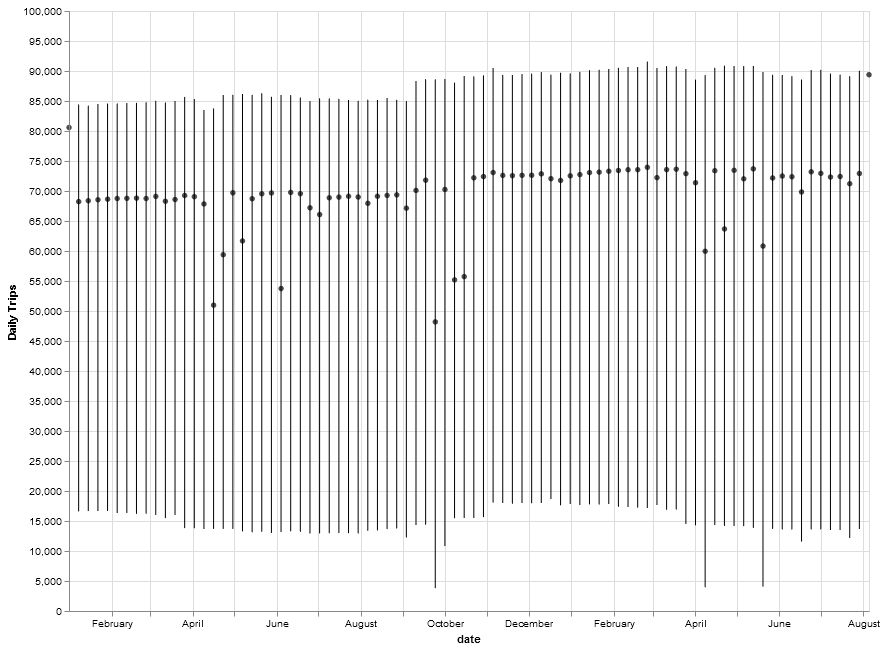

In [13]:
points = alt.Chart(total_trips).mark_point(filled=True).encode(
    alt.Y(
        'mean',
        scale=alt.Scale(zero=False),
        axis=alt.Axis(title='Daily Trips')
    ),
    x='date:T',
    color=alt.value('black')
)

error_bars = alt.Chart(total_trips).mark_rule().encode(
    x='date:T',
    y='min',
    y2='max'
)

(points + error_bars).properties(height=600, width=800)

In [14]:
weekday_total = (rs.set_index('date').resample('D').num_trips.sum().reset_index()
                 .assign(dayofweek = lambda x: x.date.dt.strftime('%A'))
                 .set_index('date'))

weekday_total =  (weekday_total[~weekday_total.dayofweek.isin(['Friday', 'Saturday'])]
                  .groupby(pd.Grouper(level=0, freq='W-SUN'))
                  .agg(['min', 'mean', 'max', 'idxmax', 'idxmin'])
                  .reset_index())
weekday_total.columns = ['date', 'weekday_min', 'weekday_mean', 'weekday_max', 'max_weekday', 'min_weekday']
alltots = total_trips.merge(weekday_total)

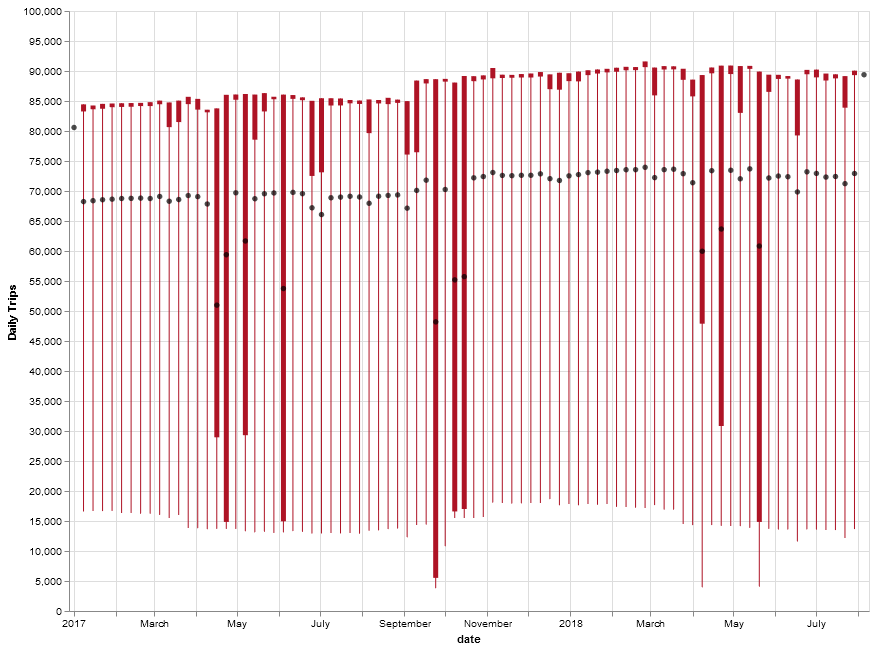

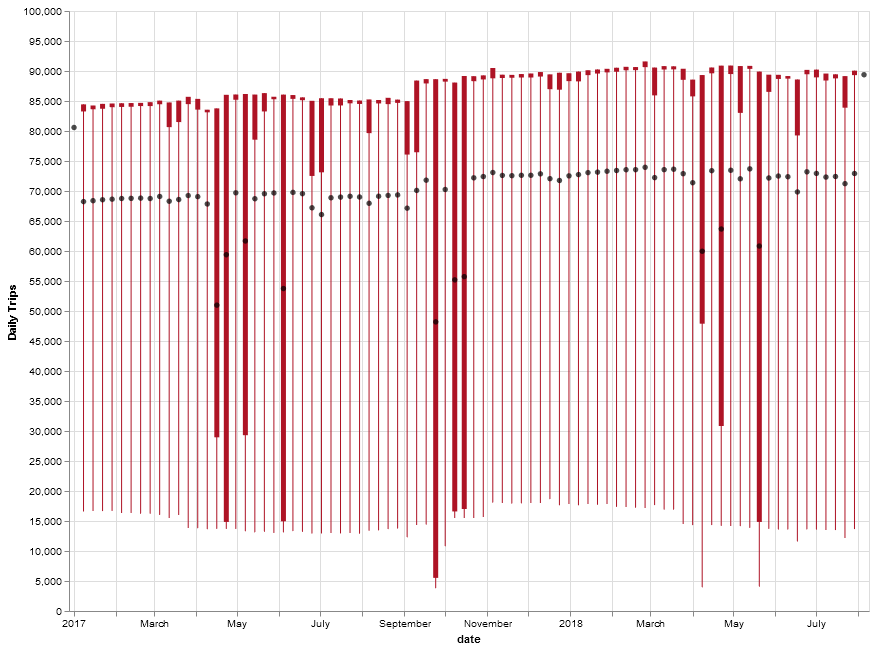

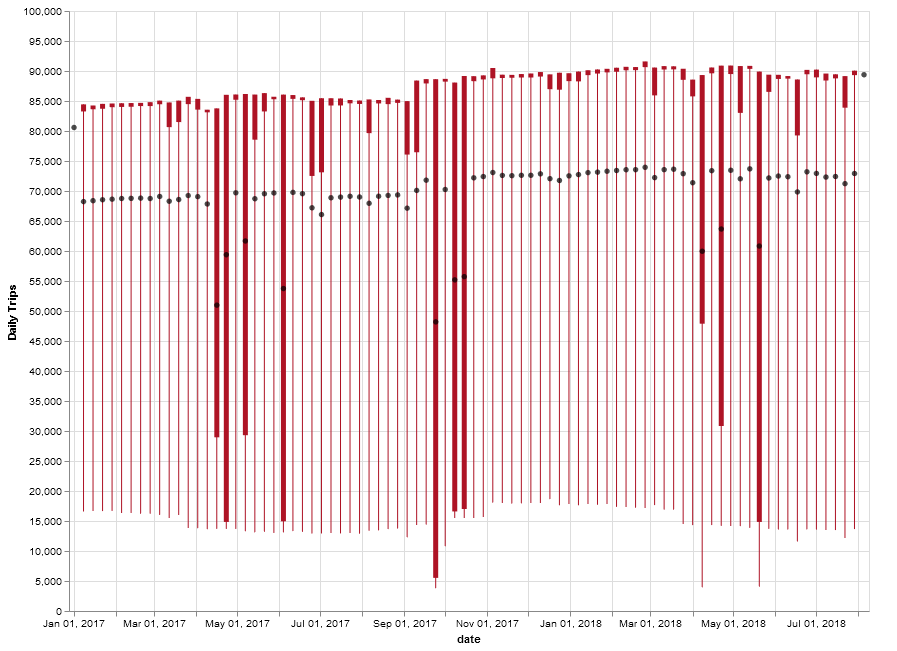

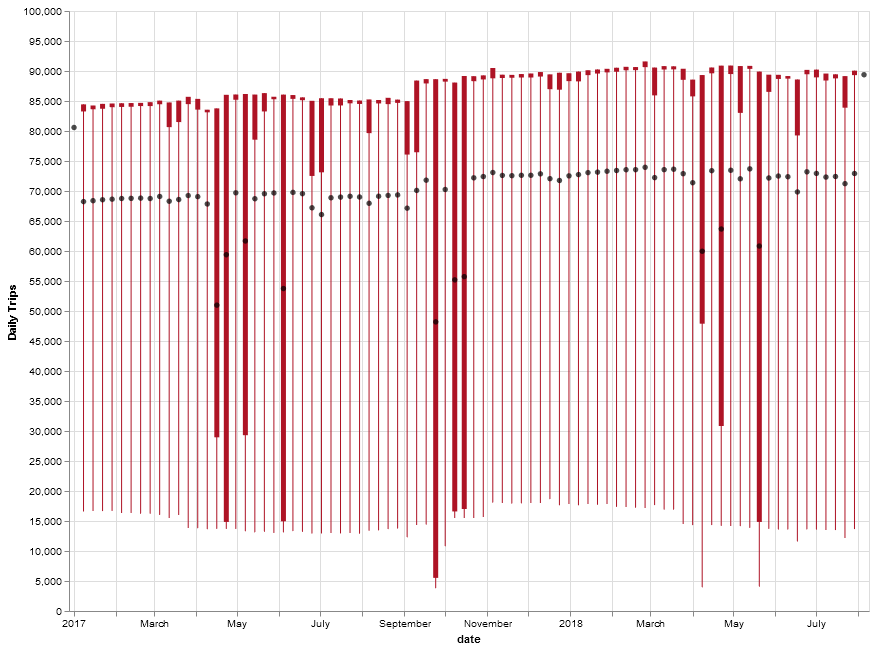

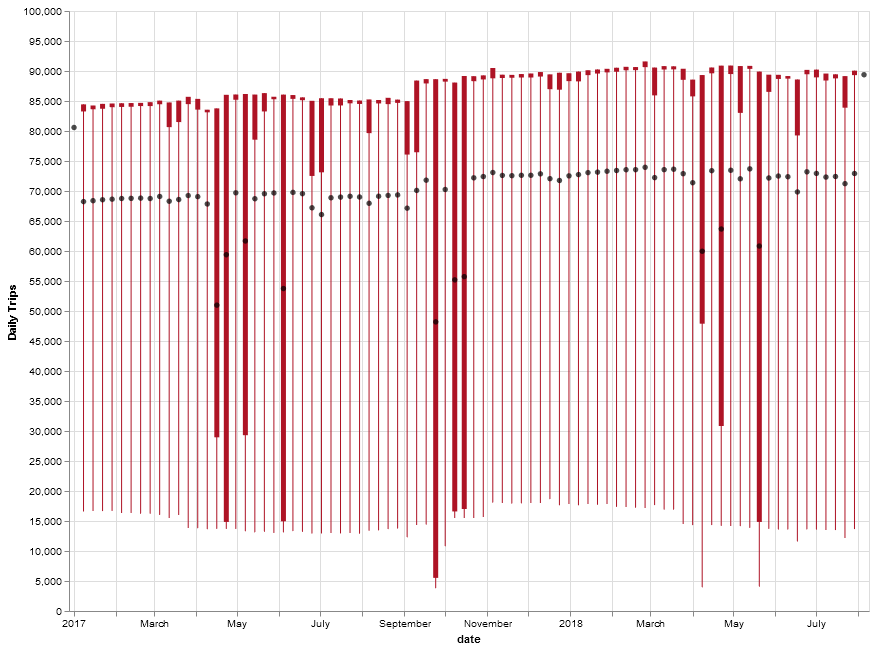

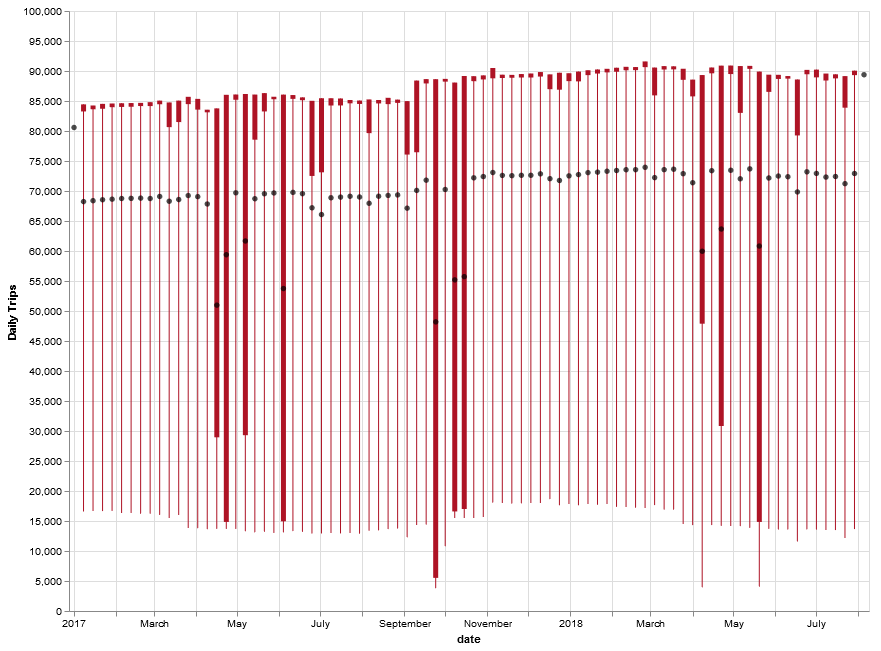

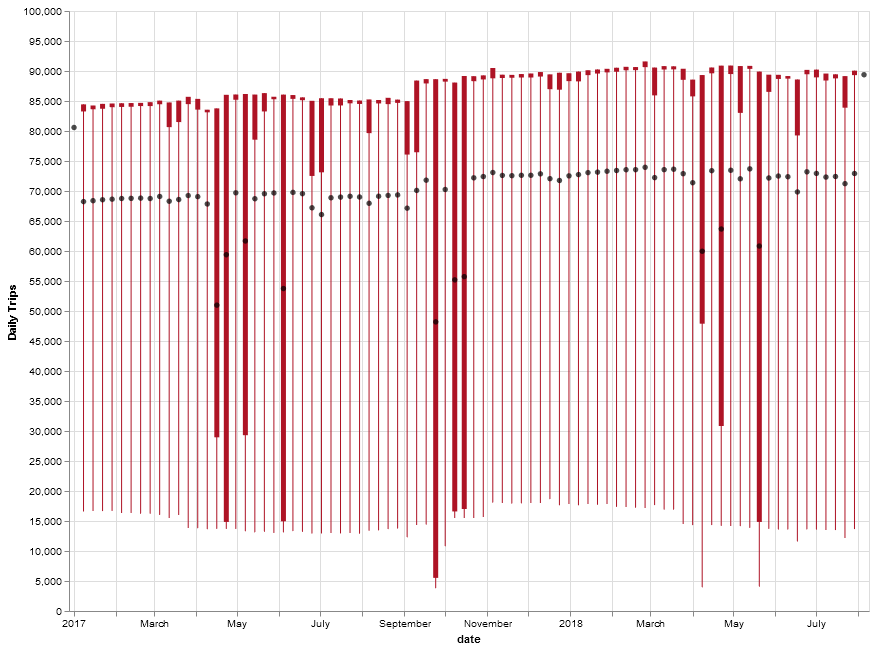

In [15]:
weekday_min_color = alt.condition("datum.weekday_min != datum.min",
                                 alt.value("#06982d"),
                                 alt.value("#ae1325"))

rule = alt.Chart(alltots).mark_rule().encode(
    alt.X(
        'date:T',
    ),
    alt.Y(
        'min',
        scale=alt.Scale(zero=False),
        axis=alt.Axis(title='Daily Trips')
    ),
    alt.Y2('max'),
    color=alt.value("#ae1325"),
    tooltip=[alt.Tooltip('date:T', format='%A, %B %e'),'min', 'max', 'mean']
)

bar = alt.Chart(alltots).mark_bar().encode(
    x='date:T',
    y='weekday_min',
    y2='weekday_max',
    color=alt.value("#ae1325"),
    tooltip=[alt.Tooltip('date:T', format='%A, %B %e'), 'weekday_mean', alt.Tooltip('min_weekday:T', format='%A, %B %e'), alt.Tooltip('max_weekday:T', format='%A, %B %e')]
)

(rule + bar + points).properties(height=600, width=800)

In [16]:
rs_zone = (rs[rs.num_trips>0]
           .groupby([pd.Grouper(key='date', freq='D'), 'start_zone'])
           .agg({'mean_headway': 'mean', 'num_trips': 'sum'})
           .reset_index()
           .assign(dayofweek = lambda x: x['date'].dt.strftime('%A'))
          )

In [17]:
rs[['mean_headway', 'num_trips']].head()

,mean_headway,num_trips
0,37.500000,26
1,28.000000,35
2,NaN,1
3,70.000000,4
4,17.142857,77


In [18]:
rs_zone.head()

,date,start_zone,mean_headway,num_trips,dayofweek
0,2017-01-01,אופקים,84.858525,627,Sunday
1,2017-01-01,אזור בית שמש,112.318522,1298,Sunday
2,2017-01-01,אזור חדרה,118.585522,578,Sunday
3,2017-01-01,אזור קריית ארבע,282.491883,92,Sunday
4,2017-01-01,אשדוד,85.245711,1877,Sunday


In [19]:
line = alt.Chart(rs_zone).mark_line().encode(
    x='date:T',
    y='mean_headway',
    color='start_zone',
).properties(height=600, width=750)

point = alt.Chart(rs_zone).mark_point(size=50).encode(
    x='date:T',
    y='mean_headway',
    color='start_zone',
    tooltip=[alt.Tooltip('start_zone:N'),
             alt.Tooltip('date:T', format='%A, %B %e'),
             alt.Tooltip('mean_headway:Q', format='.2f')],
    opacity=alt.value(0)

).properties(height=600, width=750, )

(line + point).interactive()


MaxRowsError: The number of rows in your dataset is greater than the maximum allowed (5000). For information on how to plot larger datasets in Altair, see the documentation

LayerChart({
  layer: [Chart({
    data:             date                 start_zone  mean_headway  num_trips dayofweek
    0     2017-01-01                     אופקים     84.858525        627    Sunday
    1     2017-01-01               אזור בית שמש    112.318522       1298    Sunday
    2     2017-01-01                  אזור חדרה    118.585522        578    Sunday
    3     2017-01-01            אזור קריית ארבע    282.491883         92    Sunday
    4     2017-01-01                      אשדוד     85.245711       1877    Sunday
    5     2017-01-01                     אשקלון     97.900521       1850    Sunday
    6     2017-01-01                    באר שבע     75.952914       3880    Sunday
    7     2017-01-01                    בית שאן    116.807306        323    Sunday
    8     2017-01-01                     בנימין    142.334742         95    Sunday
    9     2017-01-01               בקעת ים המלח    209.166667         12    Sunday
    10    2017-01-01                     גוש דן   

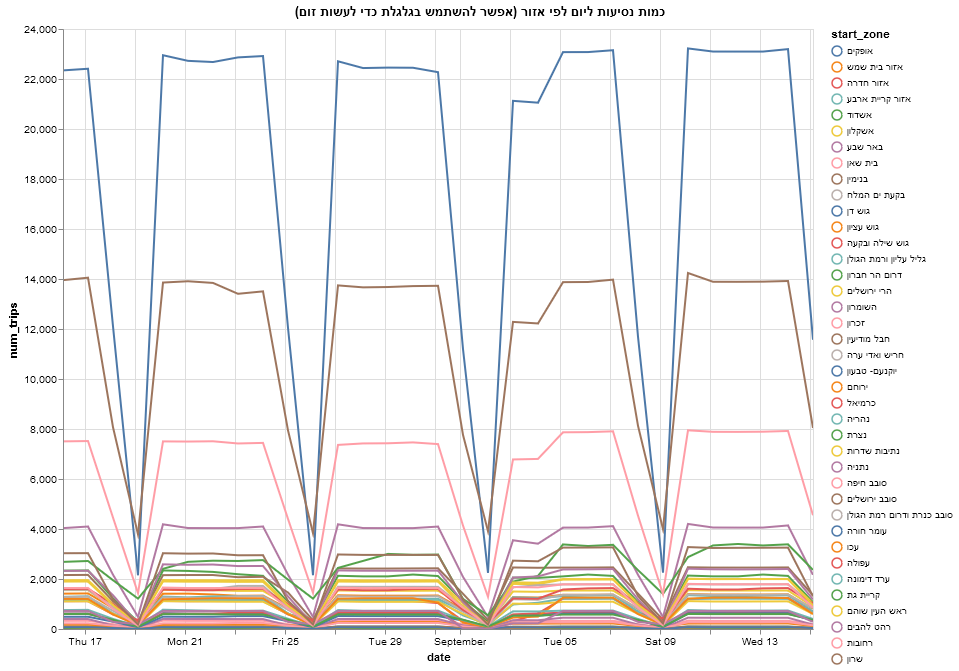

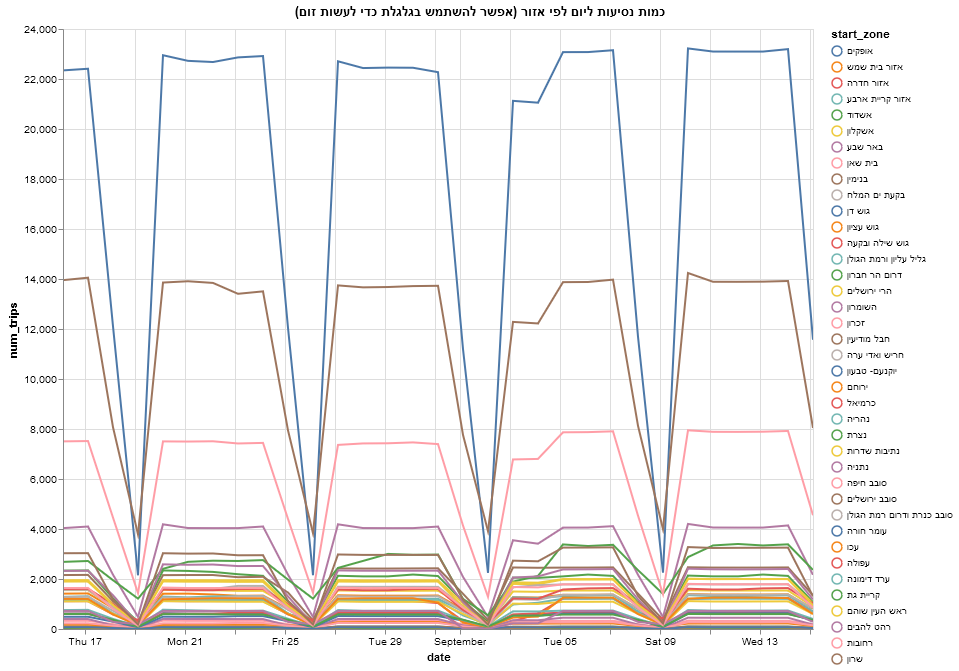

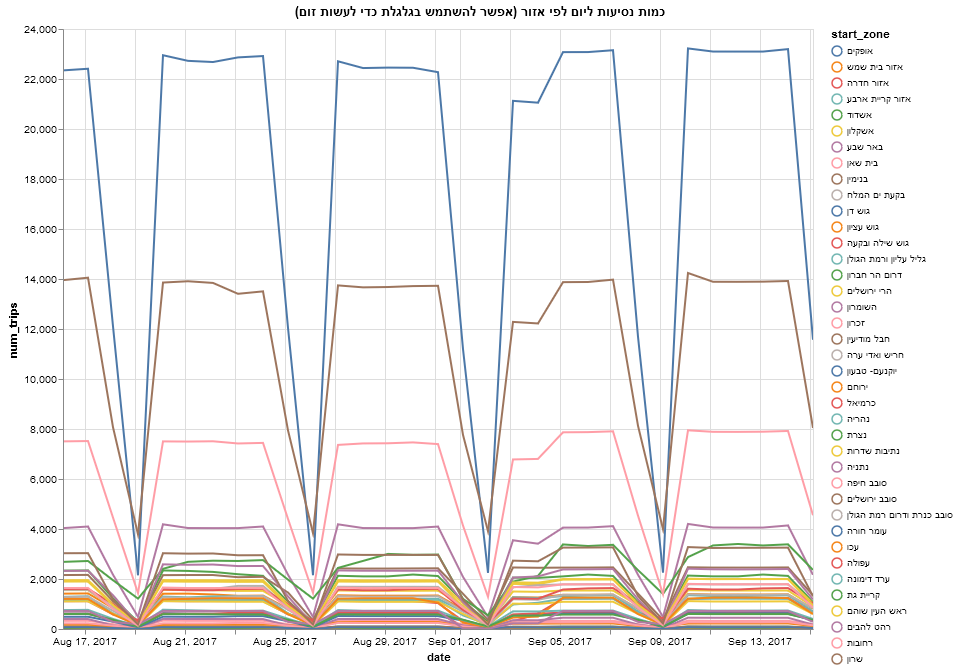

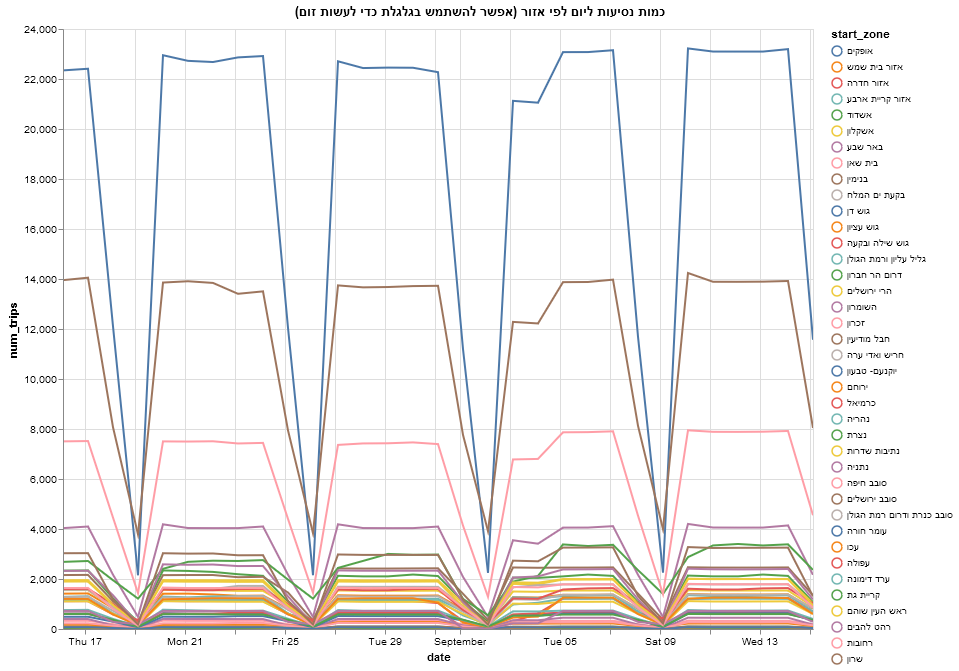

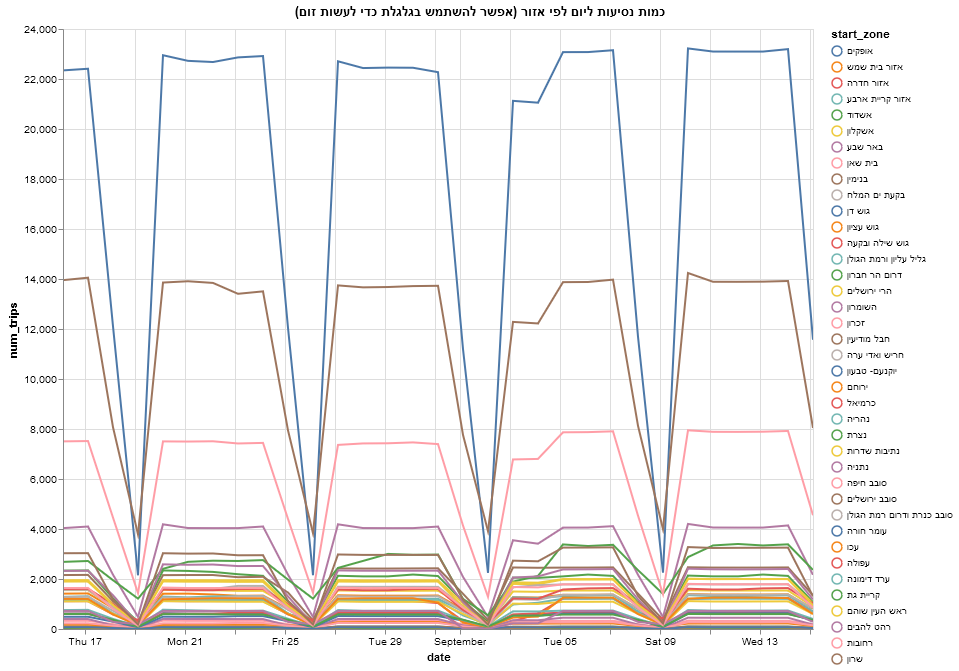

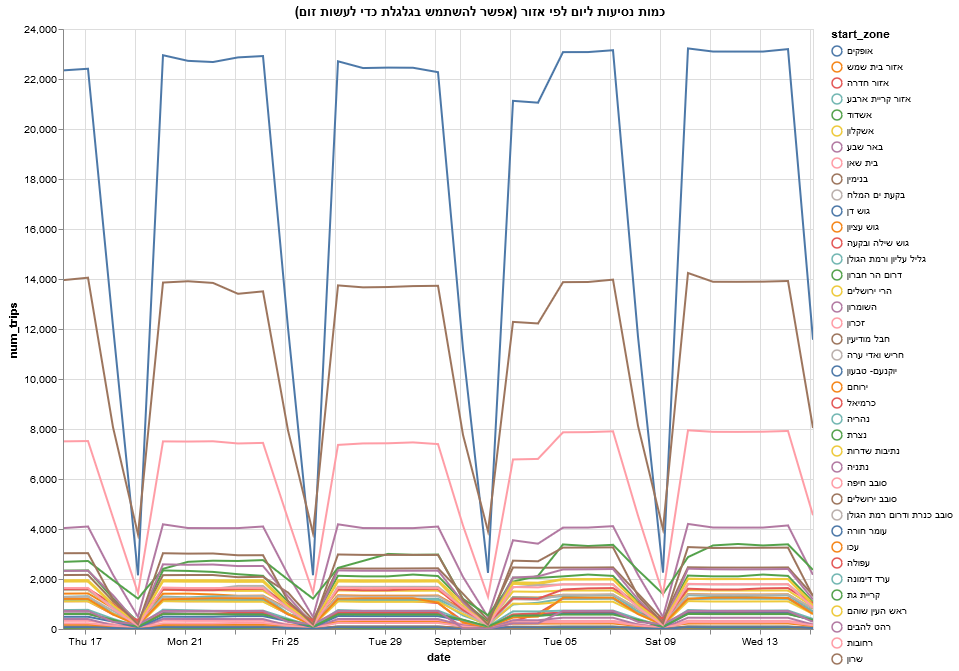

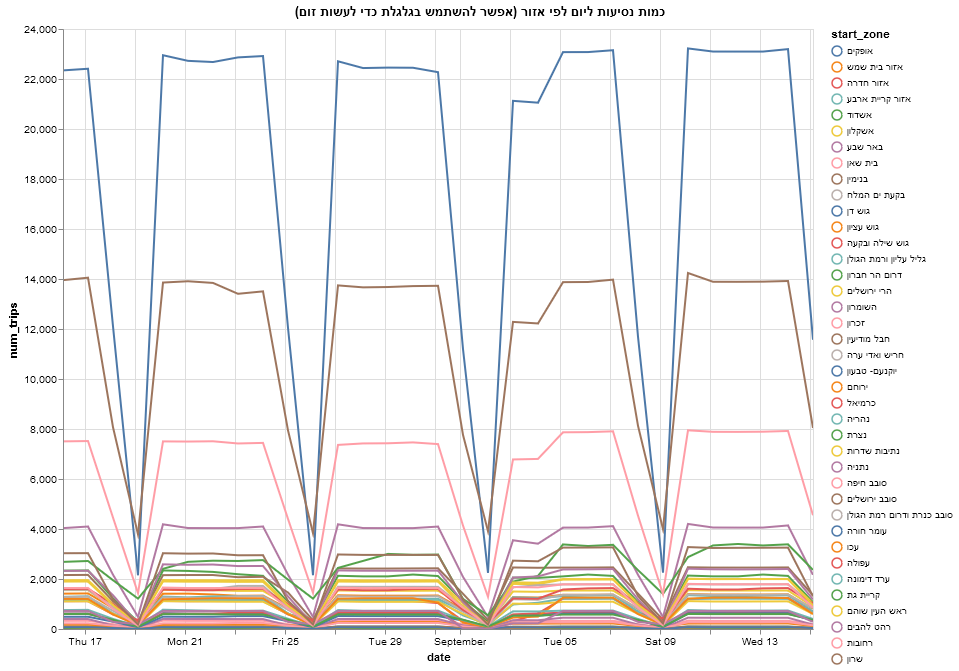

In [20]:
line = alt.Chart(rs_zone[(rs_zone.date>'2017-08-15') & (rs_zone.date <='2017-09-15')]).mark_line().encode(
    x='date:T',
    y='num_trips',
    color='start_zone',
    tooltip=[alt.Tooltip('start_zone:N'),
             alt.Tooltip('date:T', format='%A, %B %e'),
             alt.Tooltip('num_trips:Q')],
).properties(height=600, width=750)

(line).properties(title='כמות נסיעות ליום לפי אזור (אפשר להשתמש בגלגלת כדי לעשות זום)').interactive()


In [21]:
line = alt.Chart(rs_zone).mark_line().encode(
    x='date:T',
    y=alt.X('num_trips', title=None),
    #color='start_zone',
    tooltip=[alt.Tooltip('start_zone:N'),
             alt.Tooltip('date:T', format='%A, %B %e'),
             alt.Tooltip('num_trips:Q')],
)

(line).properties(height=100, width=700).facet(
    row='start_zone',
).resolve_scale(
    y='independent'
)


MaxRowsError: The number of rows in your dataset is greater than the maximum allowed (5000). For information on how to plot larger datasets in Altair, see the documentation

FacetChart({
  data:             date                 start_zone  mean_headway  num_trips dayofweek
  0     2017-01-01                     אופקים     84.858525        627    Sunday
  1     2017-01-01               אזור בית שמש    112.318522       1298    Sunday
  2     2017-01-01                  אזור חדרה    118.585522        578    Sunday
  3     2017-01-01            אזור קריית ארבע    282.491883         92    Sunday
  4     2017-01-01                      אשדוד     85.245711       1877    Sunday
  5     2017-01-01                     אשקלון     97.900521       1850    Sunday
  6     2017-01-01                    באר שבע     75.952914       3880    Sunday
  7     2017-01-01                    בית שאן    116.807306        323    Sunday
  8     2017-01-01                     בנימין    142.334742         95    Sunday
  9     2017-01-01               בקעת ים המלח    209.166667         12    Sunday
  10    2017-01-01                     גוש דן     54.677257      22302    Sunday
  11    2

In [22]:
(line).properties(height=100, width=700).facet(
    row='start_zone',
).resolve_scale(
    y='independent'
).save('zones_separate.html')

In [23]:
(line).properties(title='כמות נסיעות ליום לפי אזור (אפשר להשתמש בגלגלת כדי לעשות זום)').interactive().save('zones.html')

In [24]:
(rs[(rs.date>='2018-03-28') & (rs.date<='2018-04-03') & (rs.start_zone=='אזור קריית ארבע')])

,route_id,route_short_name,agency_id,agency_name,route_long_name,route_type,num_trips,num_trip_starts,num_trip_ends,is_loop,...,start_stop_lon,end_stop_lat,end_stop_lon,num_stops,start_zone,end_zone,num_zones,num_zones_missing,date,dayofweek
2930,18133,381,4,אגד תעבורה,בית רומנו-הר חברון<->תחנה מרכזית ירושלים/הורדה...,3,23,23,22,0,...,35.105053,31.789115,35.202598,32,אזור קריית ארבע,סובב ירושלים,3,0,2018-03-28,Wednesday
2937,18220,365,4,אגד תעבורה,'מיצד א-אספר<->משרד החוץ/שד' רבין-ירושלים-21,3,5,5,5,0,...,35.187969,31.782900,35.202218,20,אזור קריית ארבע,סובב ירושלים,3,0,2018-03-28,Wednesday
2946,18279,43,4,אגד תעבורה,כרמי צור/מזכירות-כרמי צור<->נחל דוד/נחל קדרון-...,3,4,4,4,0,...,35.101503,31.643697,35.244932,26,אזור קריית ארבע,גוש עציון,2,0,2018-03-28,Wednesday
2978,18611,42,4,אגד תעבורה,'מיצד א-אספר<->בי''ס אזורי גוש עציון-גוש עציון-21,3,3,3,3,0,...,35.187969,31.657896,35.119988,12,אזור קריית ארבע,גוש עציון,2,0,2018-03-28,Wednesday
3002,18798,380,4,אגד תעבורה,שד. כלב בן יפונה/דוד המלך-קרית ארבע<->תחנה מרכ...,3,14,14,14,0,...,35.118344,31.789115,35.202598,26,אזור קריית ארבע,סובב ירושלים,3,0,2018-03-28,Wednesday
3009,18864,260,4,אגד תעבורה,בית רומנו-הר חברון<->בנייני האומה-ירושלים-21,3,1,1,1,0,...,35.105053,31.787932,35.203427,44,אזור קריית ארבע,סובב ירושלים,3,0,2018-03-28,Wednesday
3023,18988,256,4,אגד תעבורה,שד. כלב בן יפונה/דוד המלך-קרית ארבע<->תחנה מרכ...,3,2,2,2,0,...,35.118344,31.609277,34.770133,31,אזור קריית ארבע,קריית גת,3,0,2018-03-28,Wednesday
3025,18990,59,4,אגד תעבורה,שד. כלב בן יפונה/דוד המלך-קרית ארבע<->'פני חבר...,3,4,4,4,0,...,35.118344,31.484680,35.164433,17,אזור קריית ארבע,דרום הר חברון,2,0,2018-03-28,Wednesday
3027,18992,57,4,אגד תעבורה,שד. כלב בן יפונה/דוד המלך-קרית ארבע<->צנובר/הב...,3,1,1,1,0,...,35.118344,31.550730,35.016428,18,אזור קריית ארבע,אזור קריית ארבע,1,0,2018-03-28,Wednesday
3028,18993,57,4,אגד תעבורה,צנובר/הברוש-אדורה<->מרכז מסחרי/יהושע בן נון-קר...,3,3,3,3,0,...,35.016428,31.530391,35.115449,20,אזור קריית ארבע,אזור קריית ארבע,1,0,2018-03-28,Wednesday


In [25]:
rs['mh_cut'] = pd.cut(rs.mean_headway, [0,10, 15, 30, 45, 60, np.inf]) 

In [26]:
zone_mh_cuts = rs.groupby(['start_zone', 'mh_cut']).size().unstack()

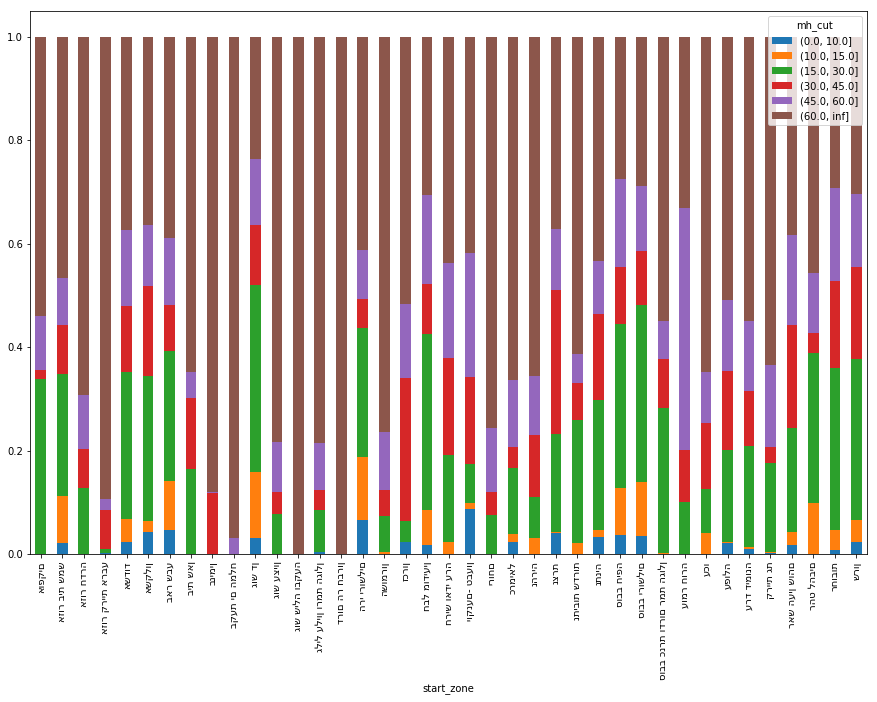

In [27]:
zone_mh_cuts.div(zone_mh_cuts.sum(axis=1), axis=0).plot(kind='bar', stacked=True, figsize=(15,10))

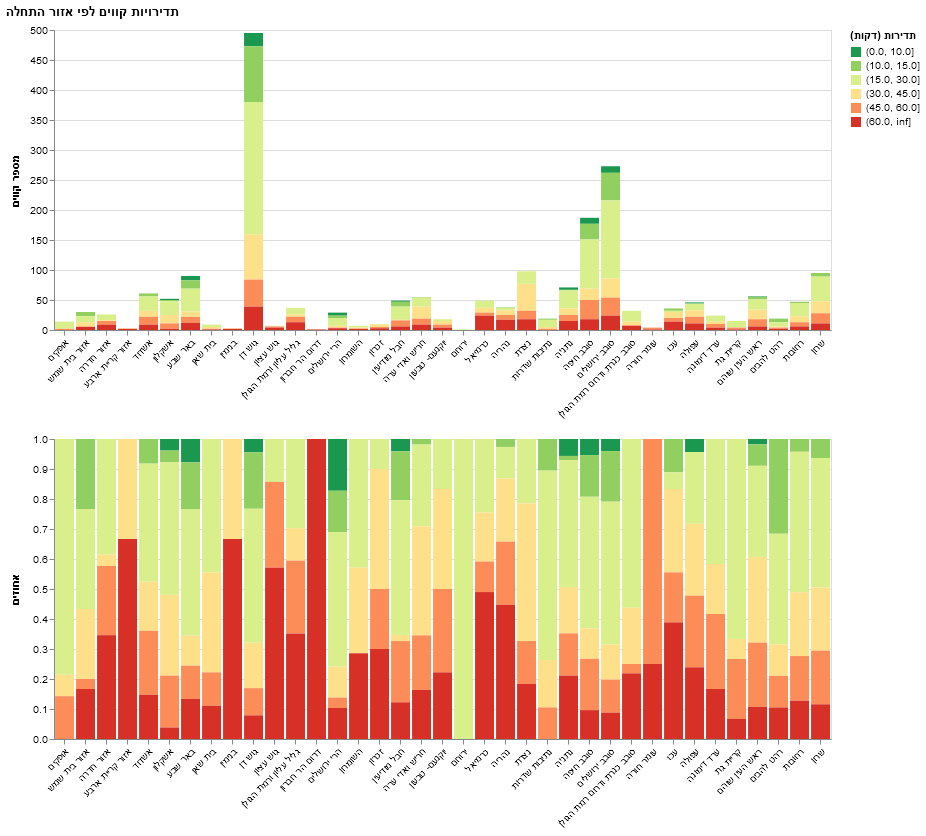

In [28]:
regular = alt.Chart(rs[(rs.date=='2018-07-15') & (rs.num_trips>10)].groupby(['start_zone', 'mh_cut']).size().reset_index().rename(columns={0:'size'})).mark_bar().encode(
    alt.X('start_zone:N', title=None),
    alt.Y('size:Q',
        axis=alt.Axis(title='מספר קווים'),
        #stack='normalize'
    ),
    alt.Color('mh_cut:O',
              scale=alt.Scale(range=['#d73027','#fc8d59','#fee08b','#d9ef8b','#91cf60','#1a9850'][::-1]),
              title='תדירות (דקות)'),
    tooltip = ['start_zone','mh_cut', 'size']
)

normalized = regular.encode(    
    alt.Y('size:Q',
        axis=alt.Axis(title='אחוזים'),
        stack='normalize'
    ),)
(regular & normalized).configure_axisX(labelAngle=-45).properties(title='תדירויות קווים לפי אזור התחלה')

In [29]:
rs[((rs.date=='2018-07-15') & (rs.num_trips>10) & (rs.mean_headway<=10))].drop_duplicates(['route_short_name', 'agency_name', 'start_zone'])[['route_short_name', 'agency_name', 'start_zone']].sort_values(['start_zone', 'agency_name', 'route_short_name'])

,route_short_name,agency_name,start_zone
2468,5,דן בדרום,אשקלון
2688,12,דן באר שבע,באר שבע
2708,3,דן באר שבע,באר שבע
2666,7,דן באר שבע,באר שבע
2669,8,דן באר שבע,באר שבע
2686,9,דן באר שבע,באר שבע
4975,480,אגד,גוש דן
1267,1,דן,גוש דן
5821,172,דן,גוש דן
4013,18,דן,גוש דן


In [30]:
rs[((rs.mean_headway<=10))].shape

(68977, 38)

In [31]:
rs[((rs.date=='2018-07-15'))].groupby(['route_short_name', 'agency_name', 'start_zone']).size().sort_values(ascending=False).reset_index()

,route_short_name,agency_name,start_zone,0
0,174,אגד,גוש דן,13
1,1,מטרופולין,שרון,12
2,101,אפיקים,השומרון,12
3,54,קווים,חבל מודיעין,11
4,1,קווים,גוש דן,10
5,480,אגד,סובב ירושלים,10
6,70,אפיקים,השומרון,10
7,13,אגד,רחובות,9
8,25,דן,גוש דן,9
9,1,אגד,חריש ואדי ערה,9


In [ ]:
rs[((rs.date=='2018-07-15'))].shape

In [ ]:
rs[rs.date.dt.month==4].groupby(['date', 'start_zone']).num_trips.sum().unstack().plot(figsize=(15,10))

In [ ]:
rs[(rs.dayofweek=='Friday')& (rs.agency_name=='רכבת ישראל')].groupby(['date', 'end_zone']).end_time.max().unstack()

In [32]:
import glob
ts = (pd.concat([pd.read_pickle(f, compression='gzip') 
                 for f in glob.glob('data\\gtfs_stats_MOD_ffill\\2018-07-30_trip_stats.pkl.gz')[:5]])
      .assign(date = lambda x: pd.to_datetime(x.date)))

In [2]:
ts.head().T
ts.iloc[0,4]

NameError: name 'ts' is not defined

In [ ]:
rs.head().T

In [ ]:
day_series = df.date.copy()

day_series[df.start_time < cutoff] = df.loc[df.start_time < cutoff, 'date'] - datetime.timedelta(days=1)

In [ ]:
rs[((rs.date=='2018-07-15') & (rs.start_zone=='שרון')& (rs.agency_name=='מטרופולין') & (rs.route_short_name.isin(['9', '19', '51', '52'])))].T

In [ ]:
rs[((rs.date=='2018-07-15') & (rs.start_zone=='שרון')& (rs.agency_name=='מטרופולין') & (rs.route_short_name.isin(['9', '19', '51', '52'])))].num_trips.sum()

In [ ]:
rs[(rs.date=='2018-07-15') & (rs.agency_name=='רכבת ישראל') & (rs.route_long_name.str.contains('ראשון'))]

In [ ]:
rs[rs.route_id.isin(['23152', '23151'])].T

## Filtered feed

In [5]:
path = 'data/filtered_feeds/2018-01-01.zip'

feed = ptg.feed(path)

In [6]:
feed.stops.head()

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,location_type,parent_station,zone_id
0,1,38831,בי''ס בר לב/בן יהודה,רחוב:בן יהודה 76 עיר: כפר סבא רציף: קומה:,32.183939,34.917812,0,NaN,221
1,2,38832,הרצל/צומת בילו,רחוב:הרצל עיר: קרית עקרון רציף: קומה:,31.870034,34.819541,0,NaN,223
2,3,38833,הנחשול/הדייגים,רחוב:הנחשול 30 עיר: ראשון לציון רציף: קומה:,31.984558,34.782815,0,NaN,210
3,4,38834,פריד/ששת הימים,רחוב:משה פריד 9 עיר: רחובות רציף: קומה:,31.888550,34.790904,0,NaN,223
4,6,38836,תחנה מרכזית לוד/הורדה,רחוב: עיר: לוד רציף: קומה:,31.956576,34.898125,0,NaN,210


## Stop coords

In [4]:
import datetime
zip_path = 'data/gtfs_feeds/2018-08-08.zip'

service_ids_by_date = ptg.read_service_ids_by_date(zip_path)  # , encoding='utf-8')
service_ids = service_ids_by_date[datetime.date(2018,8,8)]

feed = ptg.feed(zip_path, view={
    'trips.txt': {
        'service_id': service_ids,
    },
},
)

In [151]:
from geopandas import GeoDataFrame, GeoSeries
from shapely.geometry import Point, Polygon

def get_routes_by_polygon_dict(feed, polygons):
    stops_subset = get_stops_by_polygons(feed, polygons)
    return get_routes_by_stops(feed, stops_subset)
    
def get_stops_by_polygons(feed, polygons):
    stops = feed.stops
    stops['Coordinates'] = list(zip(stops.stop_lon, stops.stop_lat))
    stops['Coordinates'] = stops['Coordinates'].apply(Point)
    stops = GeoDataFrame(stops, geometry='Coordinates')
    
    ins = []

    for name, poly in polygons.items():
        ins.append(stops.intersects(poly).rename(name))
    
    all_polys = (pd.concat(ins, axis=1))
    stops = pd.concat([stops, all_polys], axis=1)

    return stops[stops[list(polygons.keys())].any(axis=1)]

def get_routes_by_stops(feed, stops_subset):
    times = feed.stop_times[feed.stop_times.stop_id.isin(stops_subset.stop_id)]
    trips = feed.trips[feed.trips.trip_id.isin(times.trip_id)]
    routes = feed.routes[feed.routes.route_id.isin(trips.route_id)]
    return routes

In [152]:
polygons = {
    'רמת החייל': Polygon([
        [34.8439722, 32.1165517],
        [34.8434572, 32.1167698],
        [34.8407106, 32.1148069],
        [34.8389511, 32.1126987],
        [34.8368912, 32.1100815],
        [34.8340588, 32.1077187],
        [34.8325567, 32.1070280],
        [34.8331575, 32.1059738],
        [34.8372774, 32.1063737],
        [34.8415689, 32.1082640],
        [34.8442726, 32.1105177],
        [34.8459034, 32.1133166],
        [34.8439722, 32.1165517]
    ]),
    'אירפורט סיטי': Polygon([
        [34.9083281, 31.9936603],
        [34.9058175, 31.9890196],
        [34.9097872, 31.9846881],
        [34.9169111, 31.9836689],
        [34.9175334, 31.9850521],
        [34.9186277, 31.9920407],
        [34.9083281, 31.9936603]
    ]),
    'קריית אריה': Polygon([
        [34.8478389, 32.1024112],
        [34.8463154, 32.0976124],
        [34.8455644, 32.0957037],
        [34.8456502, 32.0934314],
        [34.8455000, 32.0920862],
        [34.8535466, 32.0922498],
        [34.8571301, 32.0919044],
        [34.8607564, 32.0915409],
        [34.8623228, 32.0914136],
        [34.8627090, 32.0943404],
        [34.8604774, 32.0987031],
        [34.8574734, 32.1015933],
        [34.8561645, 32.1024476],
        [34.8478389, 32.1024112]
    ]),
    'רמת סיב': Polygon([
        [34.8617005, 32.0921662],
        [34.8538041, 32.0929479],
        [34.8517013, 32.0847489],
        [34.8603272, 32.0841672],
        [34.8617005, 32.0921662]
    ]),
    'צקפוסט': Polygon([
        [35.0267444, 32.7892841],
        [35.0343661, 32.7775906],
        [35.0402026, 32.7755338],
        [35.0431638, 32.7733869],
        [35.0489359, 32.7705001],
        [35.0505109, 32.7718028],
        [35.0498886, 32.7755014],
        [35.0397434, 32.7840130],
        [35.0458503, 32.7915786],
        [35.0450778, 32.7956912],
        [35.0419879, 32.7965931],
        [35.0383315, 32.7948398],
        [35.0267444, 32.7892841]
    ])
}



In [153]:
routes = get_routes_by_polygon_dict(feed, polygons)

In [154]:
routes.to_csv('data/routes_from_polygons_180808_3.csv')